# RGI-07: Region 05 (Greenland Periphery)
##### F. Maussion, S. Galos & F. Roura-Adseiras, November 2021

Goal: same as RGI6

In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import subprocess
import os
import numpy as np
from utils import mkdir

## Files and storage paths

In [2]:
# Region of interest
reg = 5

# go down from rgi7_scripts/workflow
data_dir = '../../rgi7_data/'

# Level 2 GLIMS files
l2_dir = os.path.join(data_dir, 'l2_sel_reg_tars')

# Output directories
output_dir = mkdir(os.path.join(data_dir, 'l3_rgi7a'))
output_dir_tar = mkdir(os.path.join(data_dir, 'l3_rgi7a_tar'))

# RGI v6 file for comparison later 
rgi6_reg_file = os.path.join(data_dir, 'l0_RGIv6', '05_rgi60_GreenlandPeriphery.zip')

### Load the input data

In [3]:
# Read L2 files
shp = gpd.read_file('tar://' + l2_dir + f'/RGI{reg:02d}.tar.gz/RGI{reg:02d}/RGI{reg:02d}.shp')

### List of submissions

In [4]:
toprint = []
for subid in shp.subm_id.unique():
    s_loc = shp.loc[shp.subm_id == subid]
    s = ''
    for c in ['subm_id', 'analysts', 'src_date']:
        toprint = s_loc[c].unique()
        if c != 'src_date':
            s += ' ' + (str(toprint[0]))
        else:
            for d in toprint:
                s += ' ' + d[:4]
    print(s)

 92.0 Jiskoot, Hester 1995
 474.0 Meyer, Joanna 2001
 475.0 Meyer, Joanna 2001
 580.0 Bolch, Tobias; Howat, Ian; LeBris, Raymond; Moelg, Nico; Negrete, A.; Paul, Frank; Rastner, Philipp 2002 2000 2000 2000 2002 2002 2001 2001 2000 1999 1999 2001 2001 1999 2000 2001 2003 2002 2000 2002 2003 2001 2007 2000 2000 2002 2001 1999 2001 2003 2001 1999 2002 2004 2002 1999 2000 2010 2001 2003 2003 2004 1994 2004 2001 2009
 696.0 Paul, Frank; Rastner, Philipp; Schaub, Yvonne 2015 2016 2016
 729.0 Paul, Frank; Rastner, Philipp 1978


## Apply selection criteria to reproduce RGI-6 for this region and check result

### Step 1: extract RGI6 from GLIMS data and do a check

In [5]:
#...extract RGI06 from GLIMS based on 'geog_area' 
RGI_ss_old = shp.loc[shp['geog_area']=='Randolph Glacier Inventory; Umbrella RC for merging the RGI into GLIMS']
print(shp['geog_area'])

0        East Central Greenland
1        East Central Greenland
2        East Central Greenland
3        East Central Greenland
4        East Central Greenland
                  ...          
25219                 Greenland
25220                 Greenland
25221                 Greenland
25222                 Greenland
25223                 Greenland
Name: geog_area, Length: 25224, dtype: object


In [6]:
# We use 'subm_id' = 580 
RGI_ss = shp.loc[shp['subm_id'] == 580].copy()

RGI_ss_729 = shp.loc[shp['subm_id'] == 729].copy()
polygon = RGI_ss_729.geometry.unary_union

#(RGI_ss != RGI_ss_old).sum() # subm_id 580 is exactly equivalent to shp['geog_area']=='Randolph Glacier Inventory; Umbrella RC for merging the RGI into GLIMS' --> 

In [7]:
#tmp = polygon.boundary

#tmp
#type(tmp)

#import loads
#from shapely.geometry import mapping
# schema of the resulting shapefile
#schema = tmp #{'geometry': 'MultiLineString','properties': {'id': 'int'}}
# save 
#with fiona.open('multiline.shp', 'w', 'ESRI Shapefile', schema)  as output:
#     output.write({'geometry':tmp,'properties': {'id':1}})
#tmp.to_file(tmp_output_dir + f'/envelope.shp')

In [8]:
# Write out selection in intermediate shape files for manual GIS review 
# (corresponding to subm_id = 580 (base inventory) and subm_id = 729 (region to be added).)
tmp_output_dir = mkdir(os.path.join(data_dir, 'l0_tmp_data', 'rgi05_inventories'))
tmp_output_dir_tar = mkdir(os.path.join(data_dir, 'l0_tmp_data'))
for subid in [580, 729]:
    s_loc = shp.loc[shp.subm_id == subid]
    s_loc.to_file(tmp_output_dir + f'/subm_{int(subid):03d}.shp')
print('Taring...')
print(subprocess.run(['tar', '-zcvf', f'{tmp_output_dir_tar}/rgi05_inventories.tar.gz', '-C', 
                      os.path.join(data_dir, 'l0_tmp_data'), 'rgi05_inventories']))

Taring...
rgi05_inventories/
rgi05_inventories/subm_580.cpg
rgi05_inventories/subm_580.dbf
rgi05_inventories/subm_580.prj
rgi05_inventories/subm_580.shp
rgi05_inventories/subm_580.shx
rgi05_inventories/subm_729.cpg
rgi05_inventories/subm_729.dbf
rgi05_inventories/subm_729.prj
rgi05_inventories/subm_729.shp
rgi05_inventories/subm_729.shx
CompletedProcess(args=['tar', '-zcvf', '../../rgi7_data/l0_tmp_data/rgi05_inventories.tar.gz', '-C', '../../rgi7_data/l0_tmp_data', 'rgi05_inventories'], returncode=0)


<AxesSubplot:>

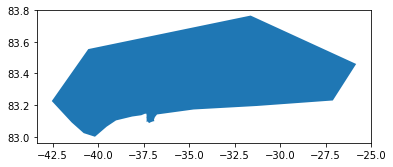

In [9]:
# Read box containing glaciers with subm_id = 729
#filename = 'tar:///' + data_dir + f'/l0_tmp_data/rgi{reg:02d}_north_outline_sel_box.zip/rgi{reg:02d}_north_outline_sel_box.shp'
#print(filename)
#shp = gpd.read_file(filename)

# For some reason I cannot open ".tar" or ".zip". 
# It may have something to do with the fact that I have the data in the windows partition + simbolic link, not in ubuntu.
filename = data_dir + f'/l0_tmp_data/rgi{reg:02d}_north_outline_sel_box/rgi{reg:02d}_north_outline_sel_box.shp'
shp = gpd.read_file(filename)

shp.plot()

/home/francesc/anaconda3/envs/geo_env/lib/python3.8/site-packages/geopandas/base.py:31: UserWarning: The indices of the two GeoSeries are different.
  warn("The indices of the two GeoSeries are different.")


0        False
24509    False
24510    False
24511    False
24512    False
         ...  
25219    False
25220    False
25221    False
25222    False
25223    False
Length: 716, dtype: bool

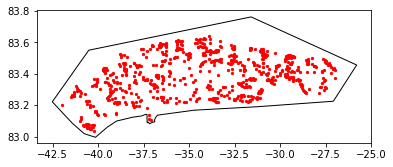

In [36]:
# create geographical points
#from shapely.geometry import Point

RGI_ss_729 = gpd.GeoDataFrame(RGI_ss_729, geometry=gpd.points_from_xy(RGI_ss_729.CenLon, RGI_ss_729.CenLat, crs=shp.crs))

base = shp.plot(color='white', edgecolor='black')
RGI_ss_729.plot(ax=base, marker='o', color='red', markersize=5)

RGI_ss_729.geometry.within(shp.envelope) # i don't understand why it says the points are not inside the shapefile!!!


#### load reference data (here RGI6) to enable comparison

In [11]:
# Just to know the name of the file to open from zip
import zipfile
with zipfile.ZipFile(rgi6_reg_file, "r") as z:
    for f in z.filelist:
        if '.shp' in f.filename:
            fname = f.filename

# load reference data
ref_odf = gpd.read_file('zip://' + rgi6_reg_file + '/' + fname)

#### Number of elements (differences do not necessarily depict major problems)

In [12]:
print('Number of glaciers in new RGI subset:', len(RGI_ss))
print('Number of glaciers in reference data:', len(ref_odf))
print('Difference:', len(RGI_ss)-len(ref_odf))

Number of glaciers in new RGI subset: 20261
Number of glaciers in reference data: 20261
Difference: 0


#### check for dublicate glacier IDs

In [13]:
print ('number of glaciers without unique id in RGI06:', len(ref_odf)-len(ref_odf['GLIMSId'].unique()))

number of glaciers without unique id in RGI06: 0


In [14]:
print ('number of glaciers without unique id in RGI06 from GLIMS data base:', len(RGI_ss)-len(RGI_ss['glac_id'].unique()))

number of glaciers without unique id in RGI06 from GLIMS data base: 0


#### Check for 'nominal glaciers' in the RGI6 original data and delete them from new RGI subset from GLIMS if they are in there 

In [15]:
# how many nominals in RGI06 (identifiable via 'Status' attribute in RGI 06)
nom = ref_odf.loc[ref_odf.Status == 2]
len(nom)

0

In [16]:
# drop nominal glaciers from new RGI subset
RGI_ss = (RGI_ss.loc[~RGI_ss['glac_id'].isin(nom['GLIMSId'])])

#### Total area

In [17]:
# add an area field to RGI_ss and reference data
RGI_ss['area'] = RGI_ss.to_crs({'proj':'cea'}).area
ref_odf['area'] = ref_odf.to_crs({'proj':'cea'}).area
nom['area'] = nom.to_crs({'proj':'cea'}).area

In [18]:
# print and compare area values
Area_Rep = RGI_ss['area'].sum()/1000000
print('Area Rep [km²]:', Area_Rep)
Area_RGI6 = ref_odf['area'].sum()/1000000
print('Area RGI6 [km²]:', Area_RGI6)
Area_nom = nom['area'].sum()/1000000
print('Area Nom [km²]:', Area_nom)
d = (Area_Rep + Area_nom - Area_RGI6)
d_perc = (d/Area_Rep*100)
print('Area difference [km²]:',d,'/','percentage:', d_perc)

Area Rep [km²]: 130632.989340823
Area RGI6 [km²]: 130071.14640016378
Area Nom [km²]: 0.0
Area difference [km²]: 561.8429406592186 / percentage: 0.43009269212493006


## result of check (RGI from Glims global data base vs. RGI06 original):
#### difference in number of glaciers: 0
#### dublicate IDs: 0
#### nominal glaciers: 0
#### area difference: 562 km² (!!!) = 0.4%
#### general comment: how comes the area difference?

## Write out and tar 

In [19]:
dd = mkdir(f'{output_dir}/RGI{reg:02d}/', reset=True)

print('Writing...')
RGI_ss.to_file(dd + f'RGI{reg:02d}.shp')

print('Taring...')
print(subprocess.run(['tar', '-zcvf', f'{output_dir_tar}/RGI{reg:02d}.tar.gz', '-C', output_dir, f'RGI{reg:02d}']))## Write out and tar 

Writing...
Taring...
RGI05/
RGI05/RGI05.cpg
RGI05/RGI05.dbf
RGI05/RGI05.prj
RGI05/RGI05.shp
RGI05/RGI05.shx
CompletedProcess(args=['tar', '-zcvf', '../../rgi7_data/l3_rgi7a_tar/RGI05.tar.gz', '-C', '../../rgi7_data/l3_rgi7a', 'RGI05'], returncode=0)


## Find missing glaciers 

In [20]:
from utils import haversine
import numpy as np
import progressbar

In [21]:
def xy_coord(geom):
    """To compute CenLon CenLat ourselves"""
    x, y = geom.xy
    return x[0], y[0]

In [22]:
df_ref = ref_odf.copy()
rgi7 = RGI_ss.copy()

In [23]:
# Remove nominal
df_ref = df_ref.loc[df_ref.Status != 2].copy()

In [24]:
# compute CenLon CenLat ourselves
rp = df_ref.representative_point()

coordinates = np.array(list(rp.apply(xy_coord)))
df_ref['CenLon'] = coordinates[:, 0]
df_ref['CenLat'] = coordinates[:, 1]

In [25]:
df_ref_orig = df_ref.copy()

In [26]:
# Loop over all RGI7 glaciers and find their equivalent in ref
df_ref = df_ref_orig.copy()
not_found = {}
to_drop = []
for i, (ref_area, lon, lat) in progressbar.progressbar(enumerate(zip(rgi7['area'].values, rgi7.CenLon.values, rgi7.CenLat.values)), max_value=len(rgi7)):
#     dist = haversine(lon, lat, df_ref.CenLon.values, df_ref.CenLat.values)
    dist = (lon - df_ref.CenLon.values)**2 + (lat - df_ref.CenLat.values)**2 
    found = False
    for j in np.argsort(dist)[:10]:
        s6 = df_ref.iloc[j]
        if np.allclose(s6['area'], ref_area, rtol=0.001):
            found = True
            to_drop.append(s6.name)
            break
    if not found:
        not_found[i] = df_ref.iloc[np.argsort(dist)[:10]]
    if len(to_drop) > 1000:
        df_ref.drop(labels=to_drop, inplace=True)
        to_drop = []
df_ref.drop(labels=to_drop, inplace=True)

100% (20261 of 20261) |##################| Elapsed Time: 0:00:25 Time:  0:00:25


In [27]:
print(len(not_found), len(df_ref))

894 894


In [28]:
pb_rgi7 = rgi7.iloc[list(not_found.keys())]

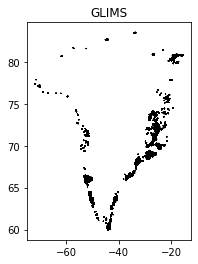

In [29]:
pb_rgi7.plot(edgecolor='k');
plt.title('GLIMS');

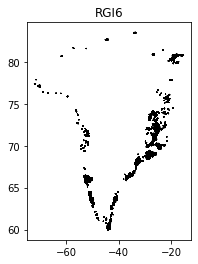

In [30]:
df_ref.plot(edgecolor='k');
plt.title('RGI6');

In [31]:
# Output directories
output_dir = mkdir(os.path.join(data_dir, 'l3_problem_glaciers'))
output_dir_tar = mkdir(os.path.join(data_dir, 'l3_problem_glaciers_tar'))

In [32]:
dd = mkdir(f'{output_dir}/RGI{reg:02d}/', reset=True)

print('Writing...')
pb_rgi7.to_file(dd + f'RGI{reg:02d}_glims.shp')
df_ref.to_file(dd + f'RGI{reg:02d}_ref.shp')

print('Taring...')
print(subprocess.run(['tar', '-zcvf', f'{output_dir_tar}/RGI{reg:02d}.tar.gz', '-C', output_dir, f'RGI{reg:02d}']))

Writing...
Taring...
RGI05/
RGI05/RGI05_glims.cpg
RGI05/RGI05_glims.dbf
RGI05/RGI05_glims.prj
RGI05/RGI05_glims.shp
RGI05/RGI05_glims.shx
RGI05/RGI05_ref.cpg
RGI05/RGI05_ref.dbf
RGI05/RGI05_ref.prj
RGI05/RGI05_ref.shp
RGI05/RGI05_ref.shx
CompletedProcess(args=['tar', '-zcvf', '../../rgi7_data/l3_problem_glaciers_tar/RGI05.tar.gz', '-C', '../../rgi7_data/l3_problem_glaciers', 'RGI05'], returncode=0)
